<h1> MNIST For ML Beginners </h1>



In [1]:
%matplotlib notebook

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision.datasets.mnist import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from collections import OrderedDict
import torch.nn.functional as F

import matplotlib.pyplot as plt
import torchvision

import numpy as  np

_cuda_ = torch.cuda.is_available()
print("Setting CUDA Availability to [%s]" % str(_cuda_))

Setting CUDA Availability to [True]


</br> </br> 

<font size=3>The MNIST database of handwritten digits, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. </font>

In this code fragment we load the MNIST data and display it.

</br> </br> 


<IPython.core.display.Javascript object>


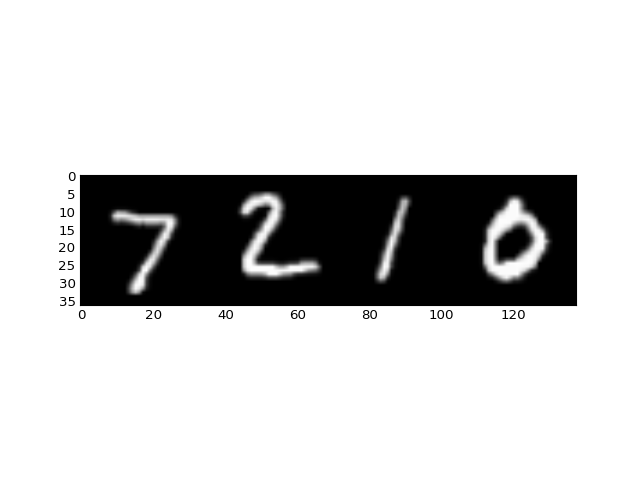

In [2]:
data_train = MNIST('./pytorch_data/mnist',
                   download=True,
                   transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor()]))
data_test = MNIST('./pytorch_data/mnist',
                  train=False,
                  download=True,
                  transform=transforms.Compose([
                      transforms.Resize((32, 32)),
                      transforms.ToTensor()]))
data_train_loader = DataLoader(data_train, batch_size=32, shuffle=True, num_workers=8)
data_test_loader = DataLoader(data_test, batch_size=32, num_workers=8)

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg.transpose(1,2,0))
    plt.show()

def display_result():
    data_test_loader = DataLoader(data_test, batch_size=4, num_workers=8, shuffle=False)
    images, labels =  next(iter(data_test_loader))
    #print labels
    imshow(torchvision.utils.make_grid(images))

display_result()

</br> </br> 
Neural networks, and multi-layered perceptrons have been shown to work quite well for a lot of problems in past including hand written digit recognition. Over here we  will design a <b>convolutional deep neural network</b> which contains several convolutional layers applied sequentially.

<img src="https://pytorch.org/tutorials/_images/mnist.png"/>
</br> </br> 

In [3]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

Now we have our data loaded and neural network, we train the neural network. We feed the neural network images we showed earlier and tell it the label corresponding to each image. Then we show it a test image and ask what the output is. The code coming below shows the error rate over learnt samples as we start training out neural network.

<IPython.core.display.Javascript object>


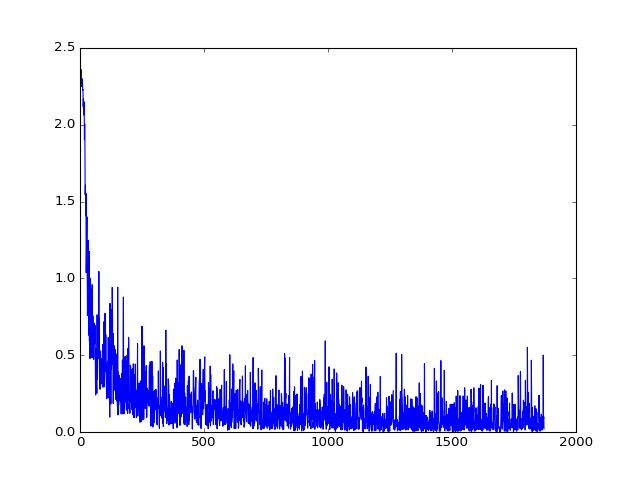

Test Avg. Loss: 0.002388, Accuracy: 0.975100


<IPython.core.display.Javascript object>


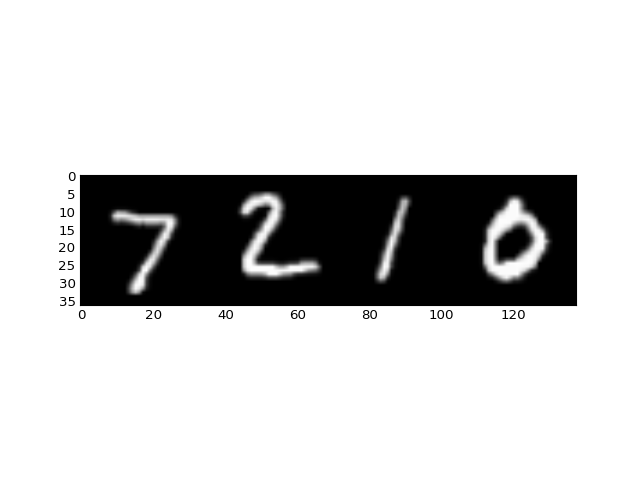

Predicted OUTPUT:  [7 2 1 0]


In [4]:
net = LeNet5()
if _cuda_:
  net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=2e-3)

cur_batch_win = None
cur_batch_win_opts = {
    'title': 'Epoch Loss Trace',
    'xlabel': 'Batch Number',
    'ylabel': 'Loss',
    'width': 1200,
    'height': 600,
}


def train(epoch):
    global cur_batch_win
    net.train()
    loss_list, batch_list = [], []
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    ax.set_xlim(0, len(data_test_loader))

    for i, (images, labels) in enumerate(data_train_loader):
        if _cuda_:
          images, labels = Variable(images.cuda()), Variable(labels.cuda())
        else:
          images, labels = Variable(images), Variable(labels)

        optimizer.zero_grad()

        output = net(images)

        loss = criterion(output, labels)

        loss_list.append(loss.data[0])
        batch_list.append(i+1)

        if i % 10 == 0:
            ax.clear()
            ax.plot(batch_list, loss_list)
            fig.canvas.draw()
            
        loss.backward()
        optimizer.step()


def test():
    net.eval()
    total_correct = 0
    avg_loss = 0.0
    for i, (images, labels) in enumerate(data_test_loader):
        if _cuda_:
          images, labels = Variable(images.cuda()), Variable(labels.cuda())
        else:
          images, labels = Variable(images), Variable(labels)
        output = net(images)
        avg_loss += criterion(output, labels).sum()
        pred = output.data.max(1)[1]
        total_correct += pred.eq(labels.data.view_as(pred)).sum()

    avg_loss /= len(data_test)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss.data[0], float(total_correct) / len(data_test)))


def train_and_test(epoch):
    train(epoch)
    test()

import matplotlib.pyplot as plt
import torchvision

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg.transpose(1,2,0))
    plt.show()

def show_prediction():
    plt.figure()
    data_test_loader = DataLoader(data_test, batch_size=4, num_workers=8, shuffle=False)
    images, labels =  next(iter(data_test_loader))
    #print labels
    if _cuda_:
      output = net(Variable(images.cuda()))
    else:
      output = net(Variable(images))
    pred = output.data.max(1)[1]
    print "Predicted OUTPUT: " , (pred.cpu().numpy())
    imshow(torchvision.utils.make_grid(images))

def main():
    for e in range(1, 2):
        train_and_test(e)
    show_prediction()


if __name__ == '__main__':
    main()